In [7]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import data, color, io, exposure
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.color import rgb2hsv, rgb2gray

Part 1: Define Functions to extract (red) circles from test images


In [26]:
def extract_signs(imagepath, show_image=False):
    # Load picture

    image_rgb = io.imread(imagepath)
    # Convert the image to the HSV color space
    hsv_image = color.rgb2hsv(image_rgb)

    # Extract the red channel (Hue) from the HSV image
    red_hue = hsv_image[:, :, 0]

    # Perform histogram equalization on the red channel
    red_hue_equalized = exposure.equalize_hist(red_hue)

    # Replace the red channel with the equalized one in the HSV image
    hsv_image[:, :, 0] = red_hue_equalized

    # Convert the HSV image back to RGB
    enhanced_image = color.hsv2rgb(hsv_image)

    # Convert the RGB image to grayscale

    image_gray = rgb2gray(enhanced_image)
    if show_image:
        print("RGB IMAGE")
        io.imshow(image_rgb)
        io.show()
        print("IMAGE WITH ENHANCED RED CHANNEL")
        io.imshow(enhanced_image)
        io.show()
        print("GRAYSCSALE IMAGE")
        io.imshow(image_gray)
        io.show()

    edges = canny(image_gray)

    # Detect multiple radii

    hough_radii = np.arange(10, 50, 1)
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent 3 circles per radius

    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, num_peaks=3)

    # Extract the parts with circles and store the subimages
    subimages = []
    for center_y, center_x, radius in zip(cy, cx, radii):
        small = image_rgb[
            center_y - radius : center_y + radius, center_x - radius : center_x + radius
        ]
        subimages.append(small)

    # Draw the circles into the image (green)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    if show_image:
        for center_y, center_x, radius in zip(cy, cx, radii):
            circy, circx = circle_perimeter(
                center_y, center_x, radius, shape=image_rgb.shape
            )

            image_rgb[circy, circx] = (20, 200, 20)

            # Show the image with circles

        ax.imshow(image_rgb)
        plt.show()
    print("Number of circles found:", len(subimages))
    return subimages

RGB IMAGE


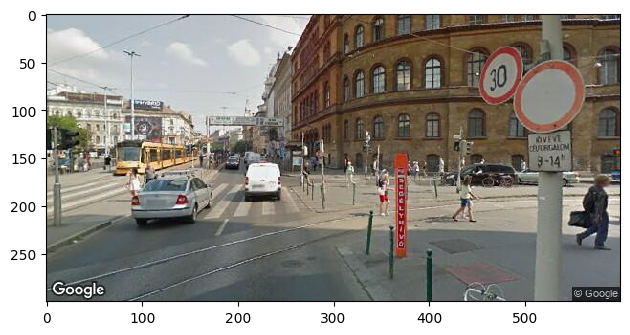

IMAGE WITH ENHANCED RED CHANNEL


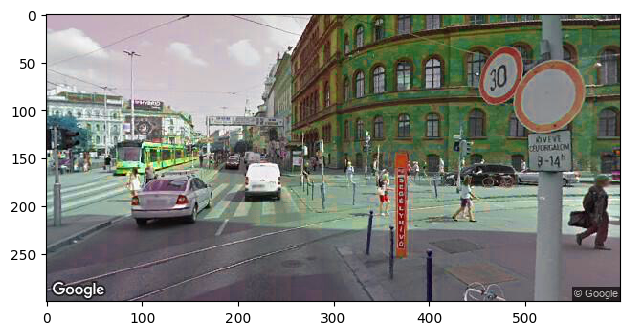

GRAYSCSALE IMAGE


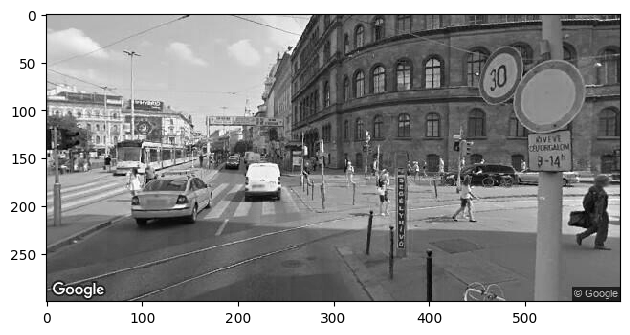

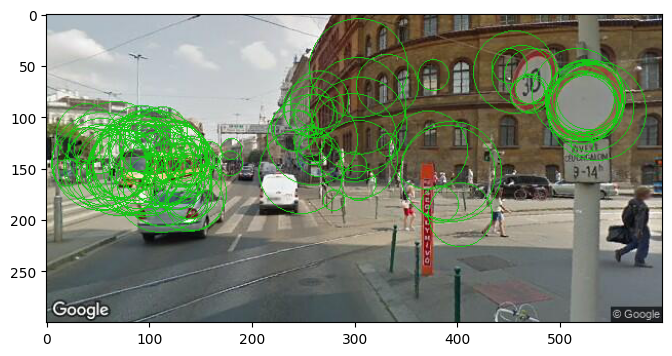

Number of circles found: 120


[array([[[144, 142, 145],
         [216, 214, 217],
         [218, 216, 219],
         ...,
         [232, 228, 229],
         [200, 194, 196],
         [230, 224, 226]],
 
        [[124, 122, 125],
         [214, 209, 213],
         [228, 223, 227],
         ...,
         [245, 236, 237],
         [171, 162, 163],
         [177, 168, 169]],
 
        [[113, 109, 110],
         [221, 215, 217],
         [239, 233, 237],
         ...,
         [245, 235, 234],
         [143, 133, 132],
         [122, 110, 110]],
 
        ...,
 
        [[225, 230, 208],
         [ 20, 200,  20],
         [150, 155, 133],
         ...,
         [ 20, 200,  20],
         [ 93,  86,  70],
         [ 20, 200,  20]],
 
        [[222, 230, 209],
         [ 20, 200,  20],
         [137, 145, 124],
         ...,
         [ 82,  80,  67],
         [ 91,  88,  73],
         [ 20, 200,  20]],
 
        [[ 20, 200,  20],
         [118, 125, 109],
         [104, 111,  95],
         ...,
         [ 73,  75,  64],
  

In [27]:
extract_signs(r"test_images\1.jpg", show_image=True)

Part 2: Build model to decide if it is a sign in the circle and categorize them

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.color import rgb2hsv
from sklearn.model_selection import train_test_split
import os
from matplotlib.image import imread
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

In [ ]:
# Path Mo
dir_path = "D:\\Studium\Master Budapest\\AIDS\\Traffic Signs Dataset"

train_path = dir_path + "\\Train"
test_path = dir_path + "\\OurTest"

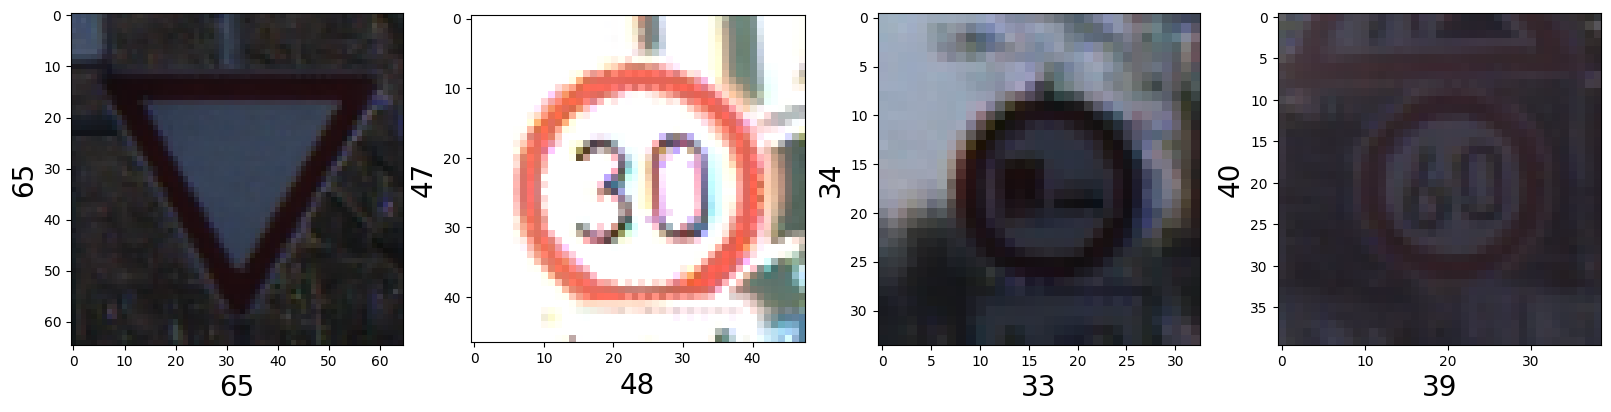

In [ ]:
# Test if pictures can be shown

import random

images_path = os.listdir(test_path)

plt.figure(figsize=(25, 25))


for i in range(1, 5):
    plt.subplot(5, 5, i)
    random_img_path = test_path + "/" + random.choice(images_path)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=20)  # width of image
    plt.ylabel(rand_img.shape[0], fontsize=20)  # height of image

In [ ]:
# Find the mean of all dimensions of all the images in training set

dim1 = []
dim2 = []

for i in range(0, 47):
    labels = train_path + "/{0}".format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + "/" + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [ ]:
# Define the shape of images: (50x50)

np.mean(dim1)
np.mean(dim2)

image_shape = (50, 50)

In [ ]:
# Categories

# 0 - 20kmh
# 1 - 30kmh
# 2 - 50kmh
# 3 - 60kmh
# 4 - 70kmh
# 5 - 80kmh
# 6 - 100kmh
# 7 - 120kmh
# 8 - Road closed
# 9 - No entry
# 10 - Red circled sign (other types of prohibitory traffic signs)
# 11 - Signs with diverse shapes (other types of prohibitory traffic signs)
# 12 - No right
# 13 - No left
# 14 - No U-turn
# 15 - No stopping

In [1]:
# Import images

from PIL import Image

images = []
label_id = []

category_mapping = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    7: 6,
    8: 7,
    15: 8,
    17: 9,
    9: 10,
    10: 10,
    16: 10,
    6: 11,
    11: 11,
    12: 11,
    13: 11,
    14: 11,
    18: 11,
    19: 11,
    20: 11,
    21: 11,
    22: 11,
    23: 11,
    24: 11,
    25: 11,
    26: 11,
    27: 11,
    28: 11,
    29: 11,
    30: 11,
    31: 11,
    32: 11,
    33: 11,
    34: 11,
    35: 11,
    36: 11,
    37: 11,
    38: 11,
    39: 11,
    40: 11,
    41: 11,
    42: 11,
    43: 12,
    44: 13,
    45: 14,
    46: 15,
}

for i in range(47):
    labels = train_path + "\\{0}".format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + "\\" + x)
        img = img.resize(image_shape)
        img = np.array(img)
        images.append(img)
        updated_label = category_mapping.get(i, 11)
        label_id.append(updated_label)

NameError: name 'train_path' is not defined

In [ ]:
# Normalize images between 0 and 1

images = np.array(images)
images = images / 255

In [ ]:
# Shapes

label_id = np.array(label_id)
print("Shape of labels: " + str(label_id.shape))

print("Shape of images: " + str(images.shape))

In [ ]:
## Checkpoint

np.save("Training_set", images)
np.save("Label_Id", label_id)

In [ ]:
# Load preprocessed data

images = np.load("Training_set.npy")
label_id = np.load("Label_Id.npy")

In [ ]:
## split the dataset

x_train, x_val, y_train, y_val = train_test_split(
    images, label_id, test_size=0.2, random_state=42
)

In [ ]:
# One-hot encoding: Target labels to categorical (Using tensorflow keras function)

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [ ]:
# Create model

model = Sequential()

# 1st layer
model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        input_shape=x_train.shape[1:],
        activation="relu",
        padding="same",
    )
)
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 2nd layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 3rd layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

# Dense layer
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(43, activation="softmax"))

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [ ]:
# Fit model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=2,
)

# Saving the model
model.save("Model.keras")

In [ ]:
##evaluate model
evaluation = pd.DataFrame(model.history.history)

evaluation[["accuracy", "val_accuracy"]].plot()
evaluation[["loss", "val_loss"]].plot()

In [ ]:
category_descriptions = {
    0: "20kmh",
    1: "30kmh",
    2: "50kmh",
    3: "60kmh",
    4: "70kmh",
    5: "80kmh",
    6: "100kmh",
    7: "120kmh",
    8: "Road closed",
    9: "No entry",
    10: "Red circled sign",
    11: "Diverse shapes and others",
    12: "No left",
    13: "No right",
    14: "No U-turn",
    15: "No stopping",
}

In [ ]:
image_path = pathlib.Path(r"/test_images")


image_paths = list(image_path.glob("*.jpg"))



for path in image_paths:
    images = extract_signs(path)

    # Predict test images

    y_pred_prob = model.predict(images)


    # Convert probabilities to class labels

    y_pred = np.argmax(y_pred_prob, axis=1)

    classes = set(y_pred)


    classes = str(category_descriptions[list(classes)])

    plt.imshow(plt.imread(path))

    plt.title("y_pred: " + classes, fontsize=12)

    plt.axis("off")



plt.tight_layout()


plt.show()